<a href="https://colab.research.google.com/github/runtorain/GenerativeDeepLearning/blob/main/03_VAE_AutoEndcoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Parameters
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
EMBEDDING_DIM = 2
EPOCHS = 20

In [4]:
# Data Preparation
transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
])

In [5]:
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 5.66MB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 62.5MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.67MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
print(train_dataset[0])

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 9)


In [7]:
train_dataset[0][0].shape

torch.Size([1, 32, 32])

In [8]:
sample_train_dataset = datasets.FashionMNIST(root="./data", train=True)

In [9]:
sample_train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 9)

In [10]:
sample_train_dataset[0][0]

In [11]:
from torchvision.transforms import ToTensor

# Example PIL image from the dataset
image, label = sample_train_dataset[0]

# Convert to PyTorch tensor
tensor_image = ToTensor()(image)

print(tensor_image.shape)  # Output: torch.Size([1, 28, 28])
print(tensor_image)

torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000,

In [12]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
  def __init__(self):
      super(Autoencoder, self).__init__()

      # Encoder
      self.encoder = nn.Sequential(
          nn.Conv2d(CHANNELS, 32, kernel_size=3, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
          nn.ReLU(),
      )

      self.flatten = nn.Flatten()
      self.fc_encode = nn.Linear(128 * 4 * 4, EMBEDDING_DIM)

      # Decoder
      self.fc_decode = nn.Linear(EMBEDDING_DIM, 128 * 4 * 4)
      self.unflatten = nn.Unflatten(1, (128, 4, 4))

      self.decoder = nn.Sequential(
          nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(32, CHANNELS, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.Sigmoid(),
      )

  def forward(self, x):
      x = self.encoder(x)
      x = self.flatten(x)
      z = self.fc_encode(x)
      x = self.fc_decode(z)
      x = self.unflatten(x)
      x = self.decoder(x)
      return x, z

  def decode_from_embedding(self, embedding):
      """
      Decode a given embedding to reconstruct the corresponding image.

      Args:
          embedding (torch.Tensor): The latent space embedding (shape: [batch_size, EMBEDDING_DIM]).

      Returns:
          torch.Tensor: The reconstructed image (shape: [batch_size, CHANNELS, IMAGE_SIZE, IMAGE_SIZE]).
      """
      x = self.fc_decode(embedding)
      x = self.unflatten(x)
      x = self.decoder(x)
      return x


In [13]:
# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [14]:
from torchinfo import summary

# Print model summary
summary(model, input_size=(BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [100, 1, 32, 32]          --
├─Sequential: 1-1                        [100, 128, 4, 4]          --
│    └─Conv2d: 2-1                       [100, 32, 16, 16]         320
│    └─ReLU: 2-2                         [100, 32, 16, 16]         --
│    └─Conv2d: 2-3                       [100, 64, 8, 8]           18,496
│    └─ReLU: 2-4                         [100, 64, 8, 8]           --
│    └─Conv2d: 2-5                       [100, 128, 4, 4]          73,856
│    └─ReLU: 2-6                         [100, 128, 4, 4]          --
├─Flatten: 1-2                           [100, 2048]               --
├─Linear: 1-3                            [100, 2]                  4,098
├─Linear: 1-4                            [100, 2048]               6,144
├─Unflatten: 1-5                         [100, 128, 4, 4]          --
├─Sequential: 1-6                        [100, 1, 32, 32]          --


In [15]:
import time

def train_model():
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        start_time = time.time()  # Record the start time

        for images, _ in train_loader:
            images = images.to(device)

            # Forward pass
            reconstructed, _ = model(images)
            loss = criterion(reconstructed, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate epoch duration
        end_time = time.time()
        epoch_duration = end_time - start_time

        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(train_loader):.4f}, Time: {epoch_duration:.2f} seconds")

def evaluate_model(loader):
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            reconstructed, embeddings = model(images)
            return images.cpu(), reconstructed.cpu(), embeddings.cpu()


In [16]:
# Train the model
train_model()

Epoch 1/20, Loss: 0.2870, Time: 17.38 seconds
Epoch 2/20, Loss: 0.2576, Time: 11.66 seconds
Epoch 3/20, Loss: 0.2544, Time: 11.78 seconds
Epoch 4/20, Loss: 0.2528, Time: 12.13 seconds
Epoch 5/20, Loss: 0.2517, Time: 11.78 seconds
Epoch 6/20, Loss: 0.2508, Time: 12.45 seconds
Epoch 7/20, Loss: 0.2499, Time: 11.73 seconds
Epoch 8/20, Loss: 0.2494, Time: 11.79 seconds
Epoch 9/20, Loss: 0.2488, Time: 11.73 seconds
Epoch 10/20, Loss: 0.2484, Time: 11.71 seconds
Epoch 11/20, Loss: 0.2480, Time: 11.74 seconds
Epoch 12/20, Loss: 0.2476, Time: 11.62 seconds
Epoch 13/20, Loss: 0.2473, Time: 11.75 seconds
Epoch 14/20, Loss: 0.2470, Time: 11.69 seconds
Epoch 15/20, Loss: 0.2467, Time: 11.74 seconds
Epoch 16/20, Loss: 0.2465, Time: 11.69 seconds
Epoch 17/20, Loss: 0.2463, Time: 11.54 seconds
Epoch 18/20, Loss: 0.2460, Time: 11.91 seconds
Epoch 19/20, Loss: 0.2459, Time: 11.63 seconds
Epoch 20/20, Loss: 0.2457, Time: 11.60 seconds


In [17]:
# Evaluate and Visualize
example_images, reconstructed_images, embeddings = evaluate_model(test_loader)

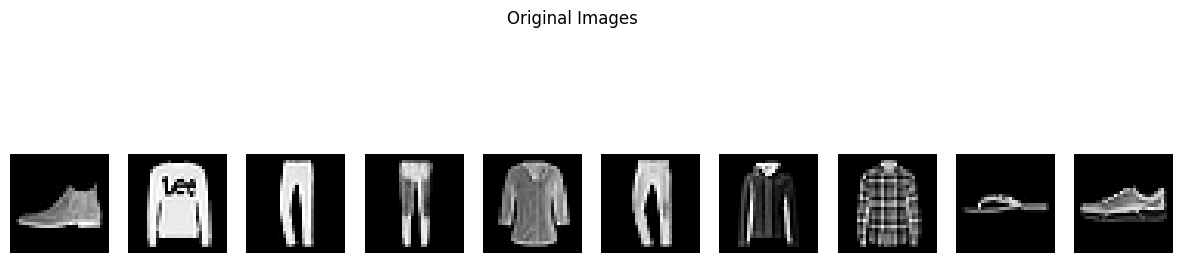

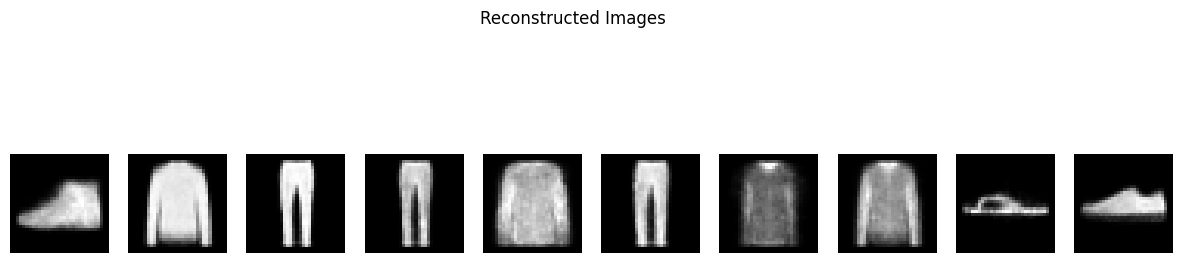

In [18]:
# Visualize Original and Reconstructed Images
def display(images, title):
    fig, axes = plt.subplots(1, 10, figsize=(15, 4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

display(example_images[:10], "Original Images")
display(reconstructed_images[:10], "Reconstructed Images")

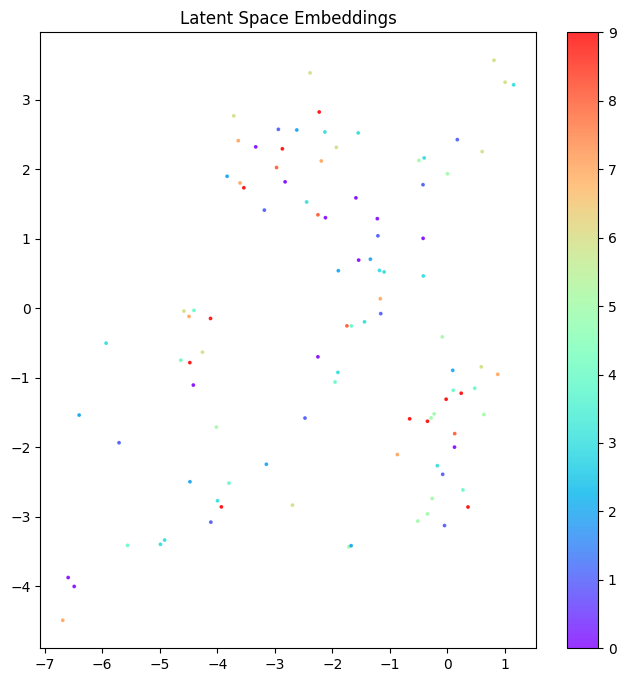

In [19]:
# Visualize Embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=train_dataset.targets[:len(embeddings)], cmap="rainbow", s=3, alpha=0.8)
plt.colorbar()
plt.title("Latent Space Embeddings")
plt.show()


In [20]:
embeddings

tensor([[ 2.4154e-01, -1.2225e+00],
        [-3.3308e+00,  2.3196e+00],
        [-6.4869e+00, -4.0010e+00],
        [-3.9953e+00, -2.7684e+00],
        [-1.2169e+00,  1.2875e+00],
        [-4.4745e+00, -2.4955e+00],
        [-1.1648e+00,  1.3624e-01],
        [-1.3373e+00,  7.0464e-01],
        [-1.7128e+00, -3.4312e+00],
        [-5.1285e-01, -3.0605e+00],
        [-2.1190e+00,  1.3014e+00],
        [-2.0356e-02, -1.3091e+00],
        [-2.2887e-01, -1.5193e+00],
        [-4.0151e+00, -1.7104e+00],
        [-3.6343e+00,  2.4089e+00],
        [-3.9287e+00, -2.8567e+00],
        [-1.2067e+00,  1.0408e+00],
        [-1.5890e+00,  1.5865e+00],
        [ 6.0573e-01,  2.2521e+00],
        [-4.4047e+00, -3.1739e-02],
        [-1.5490e+00,  2.5203e+00],
        [-8.0039e-02, -2.3888e+00],
        [ 2.7206e-01, -2.6134e+00],
        [ 1.2870e-01, -1.8033e+00],
        [-3.7964e+00, -2.5147e+00],
        [-1.0983e+00,  5.2145e-01],
        [-2.8203e+00,  1.8166e+00],
        [-6.4014e+00, -1.536

In [21]:
# Assuming embeddings is your tensor
first_dim_min = embeddings[:, 0].min().item()
first_dim_max = embeddings[:, 0].max().item()

second_dim_min = embeddings[:, 1].min().item()
second_dim_max = embeddings[:, 1].max().item()

print(f"First dimension - Min: {first_dim_min}, Max: {first_dim_max}")
print(f"Second dimension - Min: {second_dim_min}, Max: {second_dim_max}")


First dimension - Min: -6.685872554779053, Max: 1.1539560556411743
Second dimension - Min: -4.487391471862793, Max: 3.5647990703582764


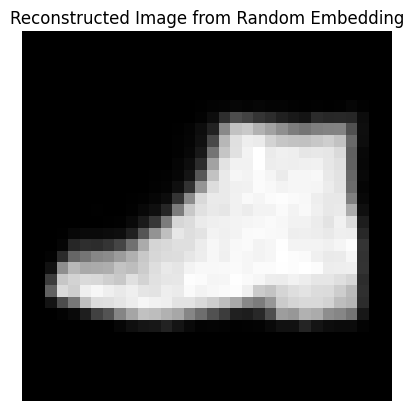

In [22]:
import torch
import matplotlib.pyplot as plt

# Generate a random embedding within the specified range
random_embedding = torch.tensor([
    torch.FloatTensor(1).uniform_(first_dim_min, first_dim_max).item(),
    torch.FloatTensor(1).uniform_(second_dim_min, second_dim_max).item()
]).to(device)

# Add batch dimension to the embedding
random_embedding = random_embedding.unsqueeze(0)  # Shape: (1, EMBEDDING_DIM)

# Decode the random embedding to generate an image
with torch.no_grad():
    decoded_image = model.fc_decode(random_embedding)
    decoded_image = model.unflatten(decoded_image)
    decoded_image = model.decoder(decoded_image)

# Convert the decoded image to CPU and detach
decoded_image = decoded_image.cpu().squeeze(0).squeeze(0)  # Remove batch and channel dimensions

# Visualize the reconstructed image
plt.imshow(decoded_image.numpy(), cmap='gray')
plt.title("Reconstructed Image from Random Embedding")
plt.axis('off')
plt.show()


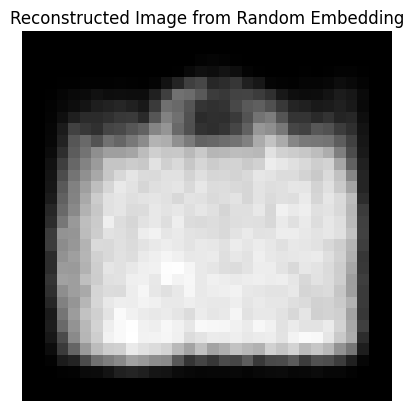

In [23]:
# Instantiate the model
# model = Autoencoder().to(device)

# Generate a random embedding
random_embedding = torch.tensor([
    torch.FloatTensor(1).uniform_(first_dim_min, first_dim_max).item(),
    torch.FloatTensor(1).uniform_(second_dim_min, second_dim_max).item()
]).to(device)

random_embedding = random_embedding.unsqueeze(0)  # Add batch dimension

# Decode the embedding
with torch.no_grad():
    reconstructed_image = model.decode_from_embedding(random_embedding)

# Visualize the reconstructed image
import matplotlib.pyplot as plt
reconstructed_image = reconstructed_image.cpu().squeeze(0).squeeze(0)  # Remove batch and channel dimensions
plt.imshow(reconstructed_image.numpy(), cmap='gray')
plt.title("Reconstructed Image from Random Embedding")
plt.axis('off')
plt.show()

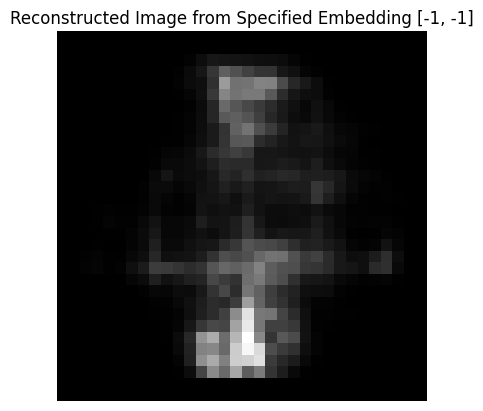

In [48]:
# Specify the embedding explicitly as [-1, -1]
specified_embedding = torch.tensor([[-1.0, -1.0]], device=device)  # Shape: (1, EMBEDDING_DIM)

# Decode the specified embedding
with torch.no_grad():
    reconstructed_image = model.decode_from_embedding(specified_embedding)

# Visualize the reconstructed image
import matplotlib.pyplot as plt
reconstructed_image = reconstructed_image.cpu().squeeze(0).squeeze(0)  # Remove batch and channel dimensions
plt.imshow(reconstructed_image.numpy(), cmap='gray')
plt.title("Reconstructed Image from Specified Embedding [-1, -1]")
plt.axis('off')
plt.show()

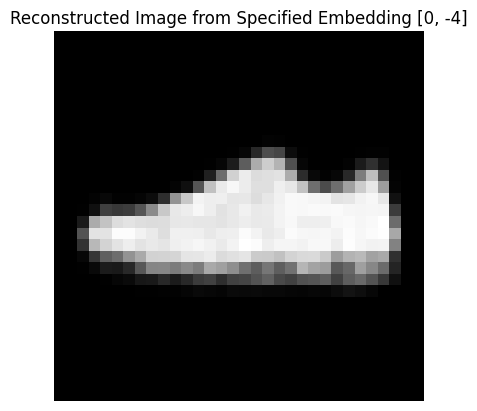

In [49]:
# Specify the embedding explicitly as [-1, -1]
specified_embedding = torch.tensor([[0, -4.0]], device=device)  # Shape: (1, EMBEDDING_DIM)

# Decode the specified embedding
with torch.no_grad():
    reconstructed_image = model.decode_from_embedding(specified_embedding)

# Visualize the reconstructed image
import matplotlib.pyplot as plt
reconstructed_image = reconstructed_image.cpu().squeeze(0).squeeze(0)  # Remove batch and channel dimensions
plt.imshow(reconstructed_image.numpy(), cmap='gray')
plt.title("Reconstructed Image from Specified Embedding [0, -4]")
plt.axis('off')
plt.show()

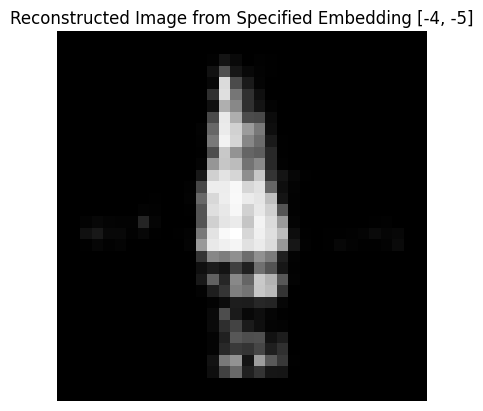

In [50]:
# Specify the embedding explicitly as [-1, -1]
specified_embedding = torch.tensor([[-4.0, -5.0]], device=device)  # Shape: (1, EMBEDDING_DIM)

# Decode the specified embedding
with torch.no_grad():
    reconstructed_image = model.decode_from_embedding(specified_embedding)

# Visualize the reconstructed image
import matplotlib.pyplot as plt
reconstructed_image = reconstructed_image.cpu().squeeze(0).squeeze(0)  # Remove batch and channel dimensions
plt.imshow(reconstructed_image.numpy(), cmap='gray')
plt.title("Reconstructed Image from Specified Embedding [-4, -5]")
plt.axis('off')
plt.show()

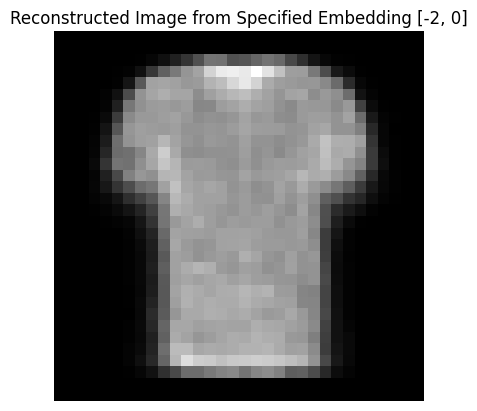

In [51]:
# Specify the embedding explicitly as [-1, -1]
specified_embedding = torch.tensor([[-2.0, 0.0]], device=device)  # Shape: (1, EMBEDDING_DIM)

# Decode the specified embedding
with torch.no_grad():
    reconstructed_image = model.decode_from_embedding(specified_embedding)

# Visualize the reconstructed image
import matplotlib.pyplot as plt
reconstructed_image = reconstructed_image.cpu().squeeze(0).squeeze(0)  # Remove batch and channel dimensions
plt.imshow(reconstructed_image.numpy(), cmap='gray')
plt.title("Reconstructed Image from Specified Embedding [-2, 0]")
plt.axis('off')
plt.show()

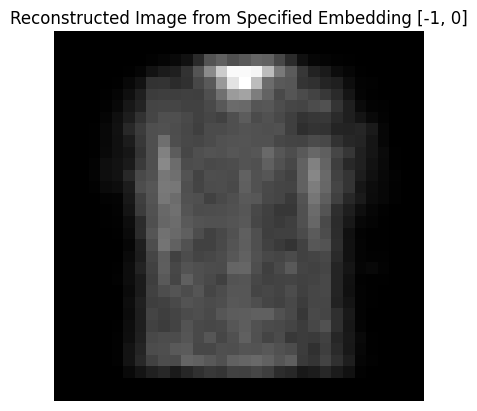

In [52]:
# Specify the embedding explicitly as [-1, -1]
specified_embedding = torch.tensor([[-1.0, 0.0]], device=device)  # Shape: (1, EMBEDDING_DIM)

# Decode the specified embedding
with torch.no_grad():
    reconstructed_image = model.decode_from_embedding(specified_embedding)

# Visualize the reconstructed image
import matplotlib.pyplot as plt
reconstructed_image = reconstructed_image.cpu().squeeze(0).squeeze(0)  # Remove batch and channel dimensions
plt.imshow(reconstructed_image.numpy(), cmap='gray')
plt.title("Reconstructed Image from Specified Embedding [-1, 0]")
plt.axis('off')
plt.show()

In [24]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Get the dataset from the DataLoader
dataset = train_loader.dataset

# Specify which image you want
image_index = 10  # Index of the desired image in the dataset
image, label = dataset[image_index]  # Access the image and its label


In [25]:
label

0

In [26]:
image

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

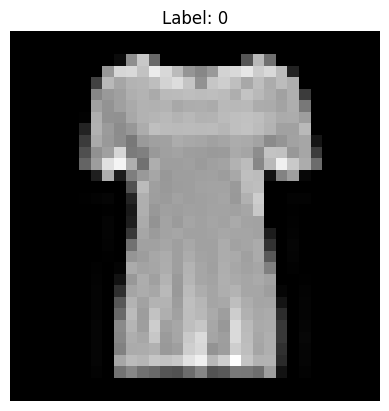

In [27]:
# Convert the tensor to a PIL image (undo normalization if necessary)
to_pil = transforms.ToPILImage()
pil_image = to_pil(image)

# Display the image
plt.imshow(pil_image, cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


In [28]:
# Save the image to a file
pil_image.save(f"image_{image_index}_label_{label}.png")
print(f"Image saved as image_{image_index}_label_{label}.png")

Image saved as image_10_label_0.png


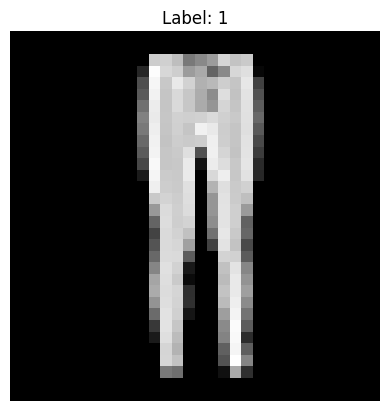

In [29]:
for batch_idx, (images, labels) in enumerate(train_loader):
    specific_image = images[5]  # Select the 5th image in this batch
    specific_label = labels[5]  # Get the corresponding label
    break  # Exit after extracting the first batch

# Convert to a PIL image
pil_image = to_pil(specific_image)

# Display and save
plt.imshow(pil_image, cmap="gray")
plt.title(f"Label: {specific_label}")
plt.axis("off")
plt.show()

# Save the image
pil_image.save(f"specific_image_label_{specific_label}.png")


In [30]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 9)

In [31]:
# Extract the first image
image = train_dataset[0][0]

# Prepare the image
image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

# Generate the embedding
model.eval()
with torch.no_grad():
    _,embedding = model(image_tensor)

# Print the embedding
embedding_np = embedding.cpu().numpy()
print("Embedding:", embedding_np)

Embedding: [[ 0.73937297 -0.5577268 ]]


In [32]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Pad(padding=2, fill=0, padding_mode=constant)
               ToTensor()
           )

In [33]:
for i in range(10):
    print(train_dataset[i][1])

9
0
0
3
0
2
7
2
5
5


In [34]:
def endcoding_reading(image):
  # Prepare the image
  image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

  # Generate the embedding
  model.eval()
  with torch.no_grad():
      _,embedding = model(image_tensor)

  # Print the embedding
  embedding_np = embedding.cpu().numpy()
  print("Embedding:", embedding_np)

  return embedding_np

In [35]:
endcoding_reading(train_dataset[1][0])

Embedding: [[-4.2484384  0.1550467]]


array([[-4.2484384,  0.1550467]], dtype=float32)

In [36]:
endcoding_reading(train_dataset[2][0])

Embedding: [[-2.2344213 -1.106786 ]]


array([[-2.2344213, -1.106786 ]], dtype=float32)

In [37]:
a = endcoding_reading(train_dataset[1][0])
b = endcoding_reading(train_dataset[2][0])

Embedding: [[-4.2484384  0.1550467]]
Embedding: [[-2.2344213 -1.106786 ]]


In [38]:
a,b

(array([[-4.2484384,  0.1550467]], dtype=float32),
 array([[-2.2344213, -1.106786 ]], dtype=float32))

In [39]:
# Flatten the arrays to 1D
a_flat = a.flatten()
b_flat = b.flatten()

# Compute cosine similarity
cosine_similarity = np.dot(a_flat, b_flat) / (np.linalg.norm(a_flat) * np.linalg.norm(b_flat))

print("Cosine Similarity:", cosine_similarity)

Cosine Similarity: 0.87930894


In [40]:
a_flat

array([-4.2484384,  0.1550467], dtype=float32)

In [41]:
c = endcoding_reading(train_dataset[0][0])
d = endcoding_reading(train_dataset[1][0])

Embedding: [[ 0.73937297 -0.5577268 ]]
Embedding: [[-4.2484384  0.1550467]]


In [42]:
# Flatten the arrays to 1D
c_flat = c.flatten()
d_flat = d.flatten()

# Compute cosine similarity
cosine_similarity = np.dot(c_flat, d_flat) / (np.linalg.norm(c_flat) * np.linalg.norm(d_flat))

print("Cosine Similarity:", cosine_similarity)

Cosine Similarity: -0.8197717


In [43]:
e = endcoding_reading(train_dataset[8][0])
f = endcoding_reading(train_dataset[9][0])

Embedding: [[-0.12289652 -0.2763503 ]]
Embedding: [[ 0.04284121 -0.3495653 ]]


In [44]:
# Flatten the arrays to 1D
e_flat = e.flatten()
f_flat = f.flatten()

# Compute cosine similarity
cosine_similarity = np.dot(e_flat, f_flat) / (np.linalg.norm(e_flat) * np.linalg.norm(f_flat))

print("Cosine Similarity:", cosine_similarity)

Cosine Similarity: 0.8575051


In [45]:
#1. Euclidean Distance
import numpy as np

# Compute Euclidean distance
euclidean_distance = np.linalg.norm(e_flat - f_flat)

print("Euclidean Distance:", euclidean_distance)


Euclidean Distance: 0.18118894


In [46]:
#1. Euclidean Distance
import numpy as np

# Compute Euclidean distance
euclidean_distance = np.linalg.norm(c_flat - d_flat)

print("Euclidean Distance:", euclidean_distance)

Euclidean Distance: 5.038482


In [47]:
#2. Manhattan Distance (L1 Norm)
# Compute Manhattan distance (L1 norm)
manhattan_distance = np.sum(np.abs(a_flat - b_flat))

print("Manhattan Distance:", manhattan_distance)


Manhattan Distance: 3.2758498


## Summary of Similarity Measures:

1.   Cosine Similarity: Measures the angle between two vectors.

2. Euclidean Distance: Measures the straight-line distance between two vectors.
3.   Manhattan Distance: Measures the sum of absolute differences between vectors.
4.   Minkowski Distance: Generalization of Euclidean and Manhattan distances.
5. Dot Product: Measures similarity without normalization (e.g., for unnormalized vectors).
6. Jaccard Similarity: Used for binary data or sets.
7. Pearson Correlation: Measures linear relationship between vectors.